In [135]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [101]:
data_all = pd.read_csv("la_crime_cleaned.csv")

In [178]:
def temporal_motifs(data_all, percentage=0.01):
    sampled_df = data_all.sample(frac=percentage, random_state=1)
    sampled_df = sampled_df.sort_values(by=['date_occured'])

    transitions = []
    
    unique_dates = sampled_df['date_occured'].unique()
    
    for i in range(len(unique_dates) - 1):
        curr_date = unique_dates[i]
        next_date = unique_dates[i + 1]
        
        curr_day_crimes = sampled_df[sampled_df['date_occured'] == curr_date]['crime_code_description'].tolist()
        next_day_crimes = sampled_df[sampled_df['date_occured'] == next_date]['crime_code_description'].tolist()
        curr_weekday = sampled_df[sampled_df['date_occured'] == curr_date]['weekday'].iloc[0]
        next_weekday = sampled_df[sampled_df['date_occured'] == next_date]['weekday'].iloc[0]
        
        for crime1 in curr_day_crimes:
            for crime2 in next_day_crimes:
                transitions.append((curr_weekday, crime1, next_weekday, crime2))
        print(transitions[-1])
    # Count the frequency of each transition
    from collections import Counter
    transitions_count = Counter(transitions)
    
    # Create a dataframe for the transitions with their weights
    motifs = pd.DataFrame(transitions_count.items(), columns=['Transition', 'weight'])
    motifs['Source'] = motifs['Transition'].apply(lambda x: x[0] + '-' + x[1])
    motifs['Target'] = motifs['Transition'].apply(lambda x: x[2] + '-' + x[3])
    motifs['Label'] = motifs['Source']
    motifs = motifs[['Source', 'Target', 'weight', 'Label']]

    motifs.to_csv(f'temporal_crime_pattern_edges_{percentage}.csv', index=False)
    
    nodes = pd.DataFrame(list(set(motifs['Source']).union(set(motifs['Target']))), columns=['id'])
    nodes['label'] = nodes['id']
    nodes.to_csv(f'temporal_crime_pattern_nodes_{percentage}.csv', index=False)

In [179]:
temporal_motifs(data_all, 0.01)

('Friday', 'Theft Of Identity', 'Saturday', 'Burglary')
('Saturday', 'Burglary', 'Sunday', 'Vandalism - Felony ($400 & Over, All Church Vandalisms) 0114')
('Sunday', 'Vandalism - Felony ($400 & Over, All Church Vandalisms) 0114', 'Monday', 'Burglary')
('Monday', 'Burglary', 'Tuesday', 'Battery - Simple Assault')
('Tuesday', 'Battery - Simple Assault', 'Wednesday', 'Intimate Partner - Simple Assault')
('Wednesday', 'Intimate Partner - Simple Assault', 'Thursday', 'Vehicle - Stolen')
('Thursday', 'Vehicle - Stolen', 'Friday', 'Theft Of Identity')
('Friday', 'Theft Of Identity', 'Saturday', 'Crm Agnst Chld (13 Or Under) (14-15 & Susp 10 Yrs Older)0060')
('Saturday', 'Crm Agnst Chld (13 Or Under) (14-15 & Susp 10 Yrs Older)0060', 'Sunday', 'Vehicle - Stolen')
('Sunday', 'Vehicle - Stolen', 'Monday', 'Burglary')
('Monday', 'Burglary', 'Tuesday', 'Theft Plain - Petty ($950 & Under)')
('Tuesday', 'Theft Plain - Petty ($950 & Under)', 'Wednesday', 'Theft-Grand ($950.01 & Over)Excpt,Guns,Fowl,L

In [180]:
edges = pd.read_csv("temporal_crime_pattern_edges_0.01.csv")
G1 = nx.from_pandas_edgelist(edges, source='Source', target='Target', edge_attr='weight', create_using=nx.DiGraph())
G1.remove_edges_from(nx.selfloop_edges(G1))

In [190]:
print("Global clustering coefficient: ", nx.transitivity(G1))

Global clustering coefficient:  0.03254296465213112


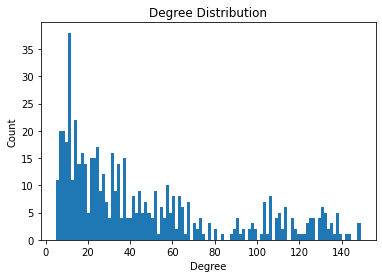

In [192]:
# plot the degree distribution as a histogram.
degrees = [d for n, d in G1.degree()]
plt.hist(degrees, bins=100)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution")
plt.show()

In [193]:
# vertex connectivity of the network
print("Vertex connectivity: ", nx.node_connectivity(G1))
# edge connectivity of the network
print("Edge connectivity: ", nx.edge_connectivity(G1))

Vertex connectivity:  1
Edge connectivity:  1


In [194]:
k_core = nx.k_core(G1)
print("Largest edge-connectivity with k-core approach: ", nx.edge_connectivity(k_core))
print("Number of nodes in the largest k-core: ", k_core.number_of_nodes())
print("Vertex connectivity of the largest k-core: ", nx.node_connectivity(k_core))

Largest edge-connectivity with k-core approach:  18
Number of nodes in the largest k-core:  182
Vertex connectivity of the largest k-core:  18


P(degree = k) as a function of k in linear scale


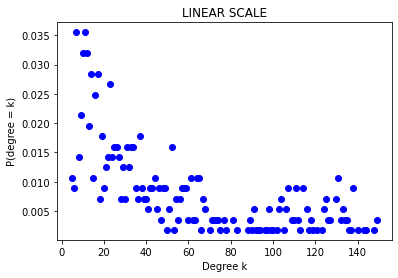

In [195]:
print("P(degree = k) as a function of k in linear scale")
degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)  # degree sequence
degreeCount = dict()
for d in degree_sequence:
    if d not in degreeCount:
        degreeCount[d] = 1
    else:
        degreeCount[d] += 1
degree, count = zip(*degreeCount.items())
total_nodes = G1.number_of_nodes()
probabilities = [c/total_nodes for c in count]
plt.plot(degree, probabilities, 'bo')
plt.xlabel('Degree k')
plt.ylabel('P(degree = k)')
plt.title('LINEAR SCALE')
plt.savefig('Linear_Scale.png')

P(degree = k) as a function of k in log-log scale with linear binning of the histogram
Slope of the line:  -0.7909625702778177
Intercept of the line:  -1.9969721686436381


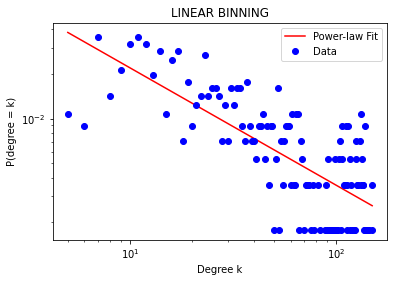

In [196]:
print("P(degree = k) as a function of k in log-log scale with linear binning of the histogram")
plt.clf()
# https://www.w3schools.com/datascience/ds_linear_slope.asp
slope, intercept = np.polyfit(np.log(degree), np.log(probabilities), 1)
print("Slope of the line: ", slope)
print("Intercept of the line: ", intercept)
gamma = -slope + 1
c_prime = np.exp(intercept)
predicted_probability_ii = [c_prime * k**(-gamma + 1) for k in degree]
plt.loglog(degree, predicted_probability_ii, 'r-', label='Power-law Fit')
plt.loglog(degree, probabilities, 'bo', label='Data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree k')
plt.ylabel('P(degree = k)')
plt.title('LINEAR BINNING')
plt.legend()
plt.savefig('Linear_Binning.png')

P(degree = k) as a function of k in log-log scale and logarithmic binning
Slope of the line:  -0.632217163552903
Intercept of the line:  -2.5716859525794713


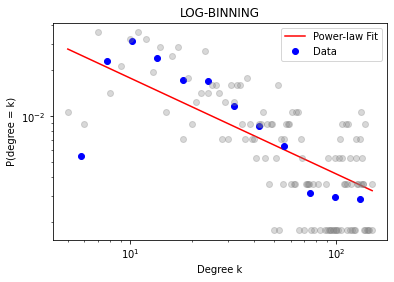

In [197]:
print("P(degree = k) as a function of k in log-log scale and logarithmic binning")
plt.clf()
# source: https://www.tutorialspoint.com/how-to-have-logarithmic-bins-in-a-python-histogram
bins = np.logspace(start=np.log10(min(degree)),stop=np.log10(max(degree)), num=13)
left_edges = bins[:-1]
right_edges = bins[1:]
centers = (left_edges + right_edges)/2
probabilities_iii, _ = np.histogram(degree_sequence, bins=bins, density=True)

non_zero_indices_center = [i for i, x in enumerate(centers) if x != 0]
non_zero_indicies_prob_iii = [i for i, x in enumerate(probabilities_iii) if x != 0]
non_zero_indicies = list(set(non_zero_indices_center).intersection(non_zero_indicies_prob_iii))

slope, intercept = np.polyfit(np.log(centers[non_zero_indicies]), np.log(probabilities_iii[non_zero_indicies]), 1)
print("Slope of the line: ", slope)
print("Intercept of the line: ", intercept)
gamma = -slope + 1
c_prime = np.exp(intercept)
predicted_probability_iii = [c_prime * k**(-gamma + 1) for k in degree]
plt.loglog(degree, predicted_probability_iii, 'r-', label='Power-law Fit')
plt.loglog(centers, probabilities_iii, 'bo', label='Data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree k')
plt.ylabel('P(degree = k)')
plt.loglog(degree, probabilities, 'bo', alpha=0.3, color='grey')
_ = plt.title('LOG-BINNING')
plt.legend()
plt.savefig('Log_Binning.png')

P(degree>k) as a function of k, i.e., the complementary cumulative distribution function (CCDF), in log-log scale.
Slope of the line:  -1.188237332719736
Intercept of the line:  3.1591690525445317


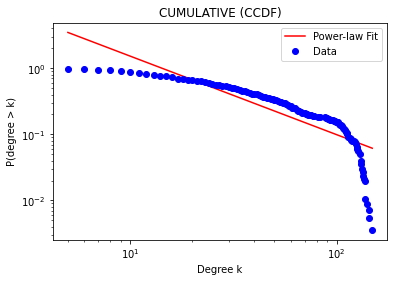

In [198]:
print("P(degree>k) as a function of k, i.e., the complementary cumulative distribution function (CCDF), in log-log scale.")
plt.clf()
ccdf = [sum(1 for d in degree_sequence if d > k) / total_nodes for k in degree]

non_zero_indices_ccdf = [i for i, x in enumerate(ccdf) if x != 0]
non_zero_indicies_degree = [i for i, x in enumerate(degree) if x != 0]
non_zero_indicies = list(set(non_zero_indices_ccdf).intersection(non_zero_indicies_degree))

slope, intercept = np.polyfit(np.log([degree[i] for i in non_zero_indicies]), np.log([ccdf[i] for i in non_zero_indicies]), 1)
print("Slope of the line: ", slope)
print("Intercept of the line: ", intercept)
gamma = -slope + 1
c_prime = np.exp(intercept)
predicted_ccdf = [c_prime * k**(-gamma + 1) for k in degree]

plt.loglog(degree, predicted_ccdf, 'r-', label='Power-law Fit')
plt.loglog(degree, ccdf, 'bo', label = 'Data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree k')
plt.ylabel('P(degree > k)')
plt.title('CUMULATIVE (CCDF)')
plt.legend()
plt.savefig('CCDF.png')